In [1]:
from Neural_Nets.LaengeNet.Development.LaengeNetTorch import LaengeNet, LaengeNetLossFunc
from Neural_Nets.ThermoDataset.Development.ThermoDataset import ThermoDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import ChenSundman, Softplus
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: LaengeNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), 5])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp, debug=True)
        
        # Get the loss
        loss, gl, sl, hl, cl = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), 
                                         h.float(), heat_cap.float(), c.float(), debug=False)
        
        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i, 0] = loss
        epoch_losses[i, 1] = gl
        epoch_losses[i, 2] = sl
        epoch_losses[i, 3] = hl
        epoch_losses[i, 4] = cl

    mean_epoch_loss = epoch_losses.mean(axis=0)
    #print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.01
    batch_size = 32
    loss_weights = [1, 1300000, 0.01, 150000]

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = LaengeNetLossFunc(weights=loss_weights)

    losses = []
    
    best_loss = epoch(net, dataloader, loss_func, optimizer)[0]
    best_net = net

    for i in range(n_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss[0])
        
        #loss_func.weights = [1, loss[1]/loss[2], loss[1]/loss[3], loss[1]/loss[4]]
        
        if loss[0] < best_loss:
            best_net = net
        
    return losses, net

In [40]:
net = LaengeNet(init_args=(0.1, 0.2), init_func=nn.init.uniform_, hidden_dim_sub_net_2=32)
theta_E_real = 1.054571817 * 10 ** -34 * 1.7 * 10 ** 13 / (1.380649 * 10 ** -23)

net.sub_net_1.act_1._initialize_parameters(theta_E_real, 0., 0., 0.)

element = 'Fe'
phase = ['BCC_A2']
start_temp, end_temp = 200, 2000

dataset = ThermoDataset(element, phase, scaling=False, step=2, start_temp=start_temp, end_temp=end_temp)

losses, best_net = train(net, dataset)

Fe successfully selected!



In [41]:
print('theta_E: ', best_net.sub_net_1.act_1.theta_E)
print('E0: ', best_net.sub_net_1.act_1.E0)
print('a: ', best_net.sub_net_1.act_1.a)
print('b: ', best_net.sub_net_1.act_1.b)

theta_E:  Parameter containing:
tensor(129.8500)
E0:  Parameter containing:
tensor(-1880.1689, requires_grad=True)
a:  Parameter containing:
tensor(3.1954, requires_grad=True)
b:  Parameter containing:
tensor(0.0320, requires_grad=True)


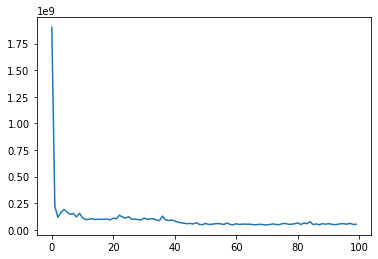

In [42]:
plt.plot(range(len(losses)), losses)

Fe successfully selected!



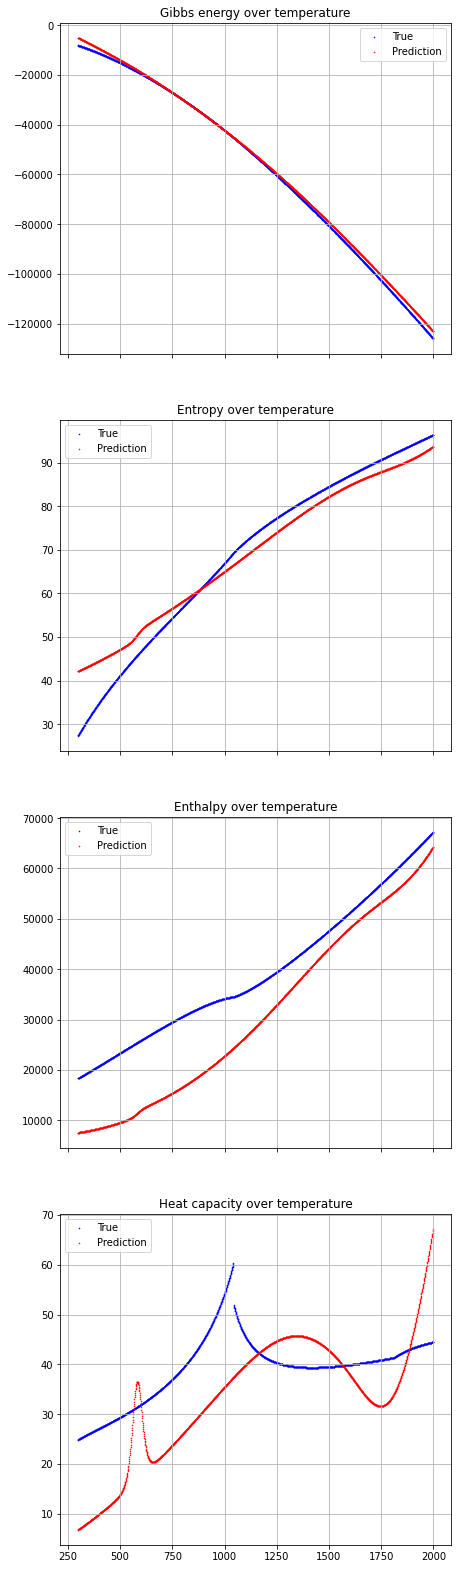

In [44]:
ph = PlotHandler('Laenge')

ph.properties_temp(best_net, element, phase, scaling=False, start_temp=start_temp, end_temp=end_temp)

In [8]:
#torch.save(net, 'Neural_Nets/LaengeNet/Models/model_07_02_22_1356')